In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import json
import os
import pickle
import re

#from src.visualizations.additional_plotting_functions import loss_archetype_plot, NMI_archetypes, plot_NMI_stability

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Plots for paper

In [3]:
my_pallette = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSOAA" : "#073B4C","GT": "#9055A2"}

In [4]:


def load_result_obj(path: str):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def load_analyses(analysis_dir: str):
    """
    Function that loads results from a given analysis.
    The format is a nested dictionary on the form results[AA_method][n_archetypes][repetition_num]
    The result objects saved have all matrices and parameters inside them. E
    """

    folder = f'C:/Users/aejew/Downloads/SynthResults/{analysis_dir}'

    results = {'RBOAA': {}, 'OAA': {}, 'CAA': {}} if 'OSM' not in analysis_dir else {'TSAA': {}}



    for method in results.keys():
        method_dir = f'{folder}/{method}_objects'
        all_files = os.listdir(method_dir)
        for file in all_files:
            obj = load_result_obj(f'{method_dir}/{file}')
            K = re.sub('[^0-9]', '', file.split('_')[1])
            rep = int(file.split('_')[-1][-1])
            if f'K{K}' not in results[method].keys():
                results[method][f'K{K}'] = {}
            
            results[method][f'K{K}'][rep] = obj
    return results


# NAIVE DATA 

In [5]:
naive_res= load_analyses("noRB_20Q_results")
naive_resQ100 = load_analyses("noRB_100Q_results")

naive_cor = load_analyses("noRB_20Q_corrupted")
naive_corQ100 = load_analyses("noRB_100Q_corrupted_results")

naive_osm = load_analyses("no_RB_OSM")
naive_osm_corr = load_analyses("no_RB_OSM_corrupted")

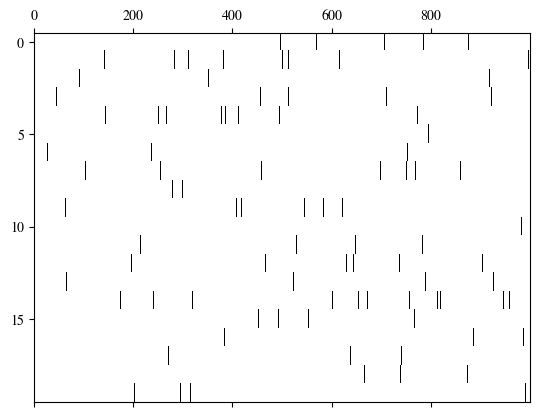

In [6]:
X = naive_res['RBOAA']['K1'][3].X
X_osm = naive_osm['TSAA']['K1'][3].X
X_cor = naive_cor['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)

In [7]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from src.visualizations.functions import findProb
from src.visualizations.functions import darken_color,hex_to_rgb

r,g,b = hex_to_rgb("#EF476F")
darkRBOAA = darken_color(r,g,b,0.5)


r,g,b = hex_to_rgb("#FFD166")
darkOAA = darken_color(r,g,b,0.5)


r,g,b = hex_to_rgb("#06D6A0")
darkAA = darken_color(r,g,b,0.5)


my_pallette = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSOAA" : "#073B4C","GT": "#9055A2",'RBOAAQ100':darkRBOAA,'OAAQ100':darkOAA,'AAQ100':darkAA}


def denoising(dataObj,dataObjCorr,dataObjOSMCorr,dataObjQ100,dataObjQ100Corr,K_list,p,figName):

    X = dataObj['CAA']['K1'][3].X
    X_cor = dataObjCorr['CAA']['K1'][3].X
    idx = np.nonzero(X-X_cor)

    X_large = dataObjQ100['CAA']['K1'][3].X
    X_large_cor = dataObjQ100Corr['CAA']['K1'][3].X
    idx2 = np.nonzero(X_large-X_large_cor)

    RMSE_CAA = np.zeros((len(K_list),10))
    RMSE_TSOAA = np.zeros((len(K_list),10))
    RMSE_RBOAA = np.zeros((len(K_list),10))
    RMSE_OAA = np.zeros((len(K_list),10))

    RMSE_RBOAAQ100 = np.zeros((len(K_list),10))
    RMSE_OAAQ100 = np.zeros((len(K_list),10))
    RMSE_AAQ100 = np.zeros((len(K_list),10))

    R_corr_CAA = np.zeros((len(K_list),10),dtype= object)
    R_corr_RBOAA = np.zeros((len(K_list),10),dtype= object)
    R_corr_OAA = np.zeros((len(K_list),10),dtype= object)
    R_corr_TSOAA = np.zeros((len(K_list),10),dtype= object)

    R_corr_RBOAAQ100 = np.zeros((len(K_list),10),dtype= object)
    R_corr_OAAQ100 = np.zeros((len(K_list),10),dtype= object)
    R_corr_AAQ100 = np.zeros((len(K_list),10),dtype= object)



    for i in range(len(K_list)): 
        for j in range(10):

            k = K_list[i]

            R_estRBOAA = findProb(dataObjCorr,'RBOAA', k, j, p)
            R_estOAA = findProb(dataObjCorr,'OAA', k, j, p)

            R_estRBOAAQ100 = findProb(dataObjQ100Corr,'RBOAA', k, j, p)
            R_estOAAQ100 = findProb(dataObjQ100Corr,'OAA', k, j, p)


            R_corr_CAA[i,j] = dataObj['CAA']['K1'][3].X@dataObjCorr['CAA'][f'K{k}'][j].B@dataObjCorr['CAA'][f'K{k}'][j].A
            R_corr_OAA[i,j] = R_estOAA.numpy() 
            R_corr_RBOAA[i,j] = R_estRBOAA.numpy() 
            R_corr_TSOAA[i,j] = dataObj['CAA']['K1'][3].X@dataObjOSMCorr['TSAA'][f'K{k}'][j].B@dataObjOSMCorr['TSAA'][f'K{k}'][j].A
            R_corr_RBOAAQ100[i,j] = R_estRBOAAQ100.numpy() 
            R_corr_OAAQ100[i,j] = R_estOAAQ100.numpy() 
            R_corr_AAQ100[i,j] = dataObjQ100['CAA']['K1'][3].X@dataObjQ100Corr['CAA'][f'K{k}'][j].B@dataObjQ100Corr['CAA'][f'K{k}'][j].A
            


    for i in range(len(K_list)):
        for j in range(10):
            RMSE_CAA[i,j] = np.sqrt(((X[idx]- R_corr_CAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
            RMSE_OAA[i,j] = np.sqrt(((X[idx]- R_corr_OAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
            RMSE_RBOAA[i,j] = np.sqrt(((X[idx]- R_corr_RBOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
            RMSE_TSOAA[i,j] = np.sqrt(((X[idx]- R_corr_TSOAA[i,j][idx])**2).sum())/np.sqrt(len(idx[1]))
            RMSE_RBOAAQ100[i,j] = np.sqrt(((X_large[idx2]-R_corr_RBOAAQ100[i,j][idx2])**2).sum())/np.sqrt(len(idx2[1]))
            RMSE_OAAQ100[i,j] = np.sqrt(((X_large[idx2]-R_corr_OAAQ100[i,j][idx2])**2).sum())/np.sqrt(len(idx2[1]))
            RMSE_AAQ100[i,j] = np.sqrt(((X_large[idx2]-R_corr_AAQ100[i,j][idx2])**2).sum())/np.sqrt(len(idx2[1]))


    fig, ax = plt.subplots(1,1, figsize = (15,5), layout='constrained')
    ax.plot(range(len(K_list)), RMSE_CAA, c = my_pallette['AA'],alpha = 0.5)
    ax.plot(range(len(K_list)), RMSE_RBOAA,c = my_pallette['RBOAA'],alpha= 0.5)
    ax.plot(range(len(K_list)), RMSE_OAA,c = my_pallette['OAA'],alpha= 0.5)
    ax.plot(range(len(K_list)), RMSE_TSOAA,c = my_pallette['TSOAA'],alpha = 0.5)
    ax.plot(range(len(K_list)), RMSE_OAAQ100,c = my_pallette['OAAQ100'],alpha= 0.5)
    ax.plot(range(len(K_list)), RMSE_RBOAAQ100,c = my_pallette['RBOAAQ100'],alpha = 0.5)
    ax.plot(range(len(K_list)), RMSE_AAQ100,c = my_pallette['AAQ100'],alpha = 0.5)

    ax.plot(range(len(K_list)), np.min(RMSE_CAA,axis = 1), c = my_pallette['AA'],label = 'AA')
    ax.plot(range(len(K_list)), np.min(RMSE_RBOAA,axis = 1),c =  my_pallette['RBOAA'],label = 'RBOAA')
    ax.plot(range(len(K_list)), np.min(RMSE_OAA,axis = 1),c =  my_pallette['OAA'],label = 'OAA')
    ax.plot(range(len(K_list)), np.min(RMSE_TSOAA,axis = 1),c =  my_pallette['TSOAA'],label = 'TSAA')

    ax.plot(range(len(K_list)), np.min(RMSE_RBOAAQ100,axis = 1),c =  my_pallette['RBOAAQ100'],label = 'RBOAA_Q100')
    ax.plot(range(len(K_list)), np.min(RMSE_OAAQ100,axis = 1),c =  my_pallette['OAAQ100'],label = 'OAA_Q100')
    ax.plot(range(len(K_list)), np.min(RMSE_AAQ100,axis = 1),c =  my_pallette['AAQ100'],label = 'AA_Q100')


    ax.set_xlabel("Number of Archetypes", fontsize = 30)
    ax.set_ylabel("RMSE", fontsize = 30)

    ax.set_xticks(range(len(K_list)))
    ax.set_xticklabels(K_list)

    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.legend(loc='upper right',fontsize = 25)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=4, fancybox=True, shadow=True,fontsize=25)

    plt.savefig("Plots_for_paper/"+figName+".png",dpi=300)



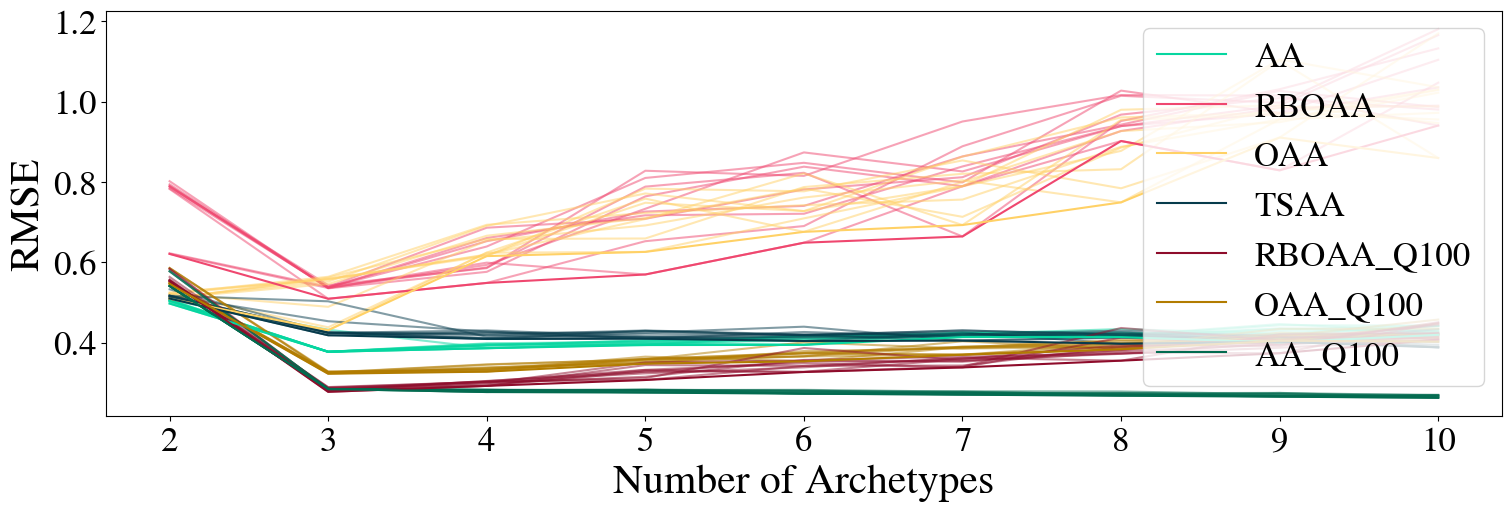

In [8]:
#from src.visualizations.denoising import denoising

K_list = [2,3,4,5,6,7,8,9,10]
p = [1,2,3,4,5]
figName = 'test'


#denoising(dataObj,dataObjCorr,dataObjOSMCorr,dataObjQ100,dataObjQ100Corr,K_list,p,figName)


denoising(naive_res,naive_cor,naive_osm_corr,naive_resQ100,naive_corQ100,K_list,p,figName)

RBOAA[8 7 6 5 4 2 1 3 0]
[8.14636621e+03 5.98056577e-02 4.17347625e-02 2.31220264e+01
 1.92204788e-02 1.21154003e-02 5.20771462e-03 3.92697472e-03
 2.92452285e-03]
OAA[8 5 7 6 4 3 2 1 0]
[1.35509307e+04 1.12997144e+03 3.05858582e+02 5.22943802e+01
 1.17858438e+01 8.58335781e+00 9.39883137e+00 9.12283421e+00
 7.62288284e+00]
AA[8 7 6 5 4 3 2 1 0]
[4688.91113281 1531.11608887 1384.68823242 1286.95947266 1206.88464355
 1136.71276855 1070.2557373  1006.40496826  951.1104126 ]
TSAA[8 7 6 5 4 3 2 1 0]
[6453.3515625  2305.85644531 2034.07800293 1803.08703613 1594.36682129
 1439.21362305 1333.02844238 1253.30871582 1148.62023926]


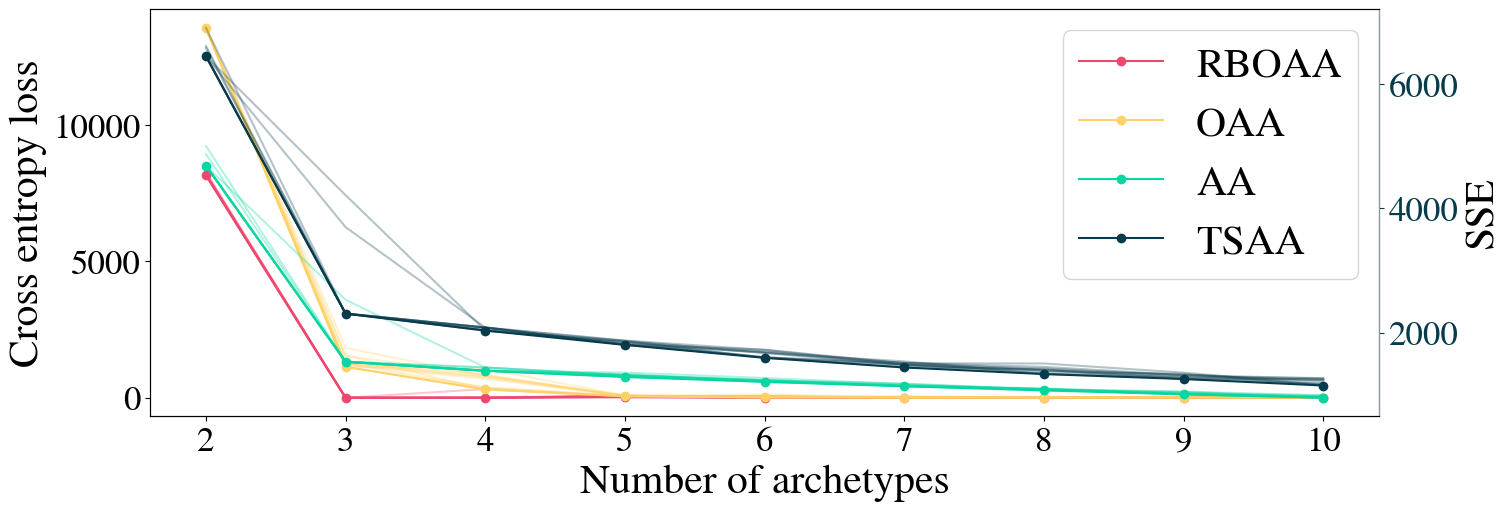

In [9]:
K_list = np.arange(2,11)
## Plot SSE
from src.visualizations. loss_archetype_plot import loss_archetype_plot

loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/SynthResults/noRB_20Q_results/all_AA_results.json',results_path2 =  'C:/Users/aejew/Downloads/SynthResults/no_RB_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/Error_K_naive.png",dpi=300)

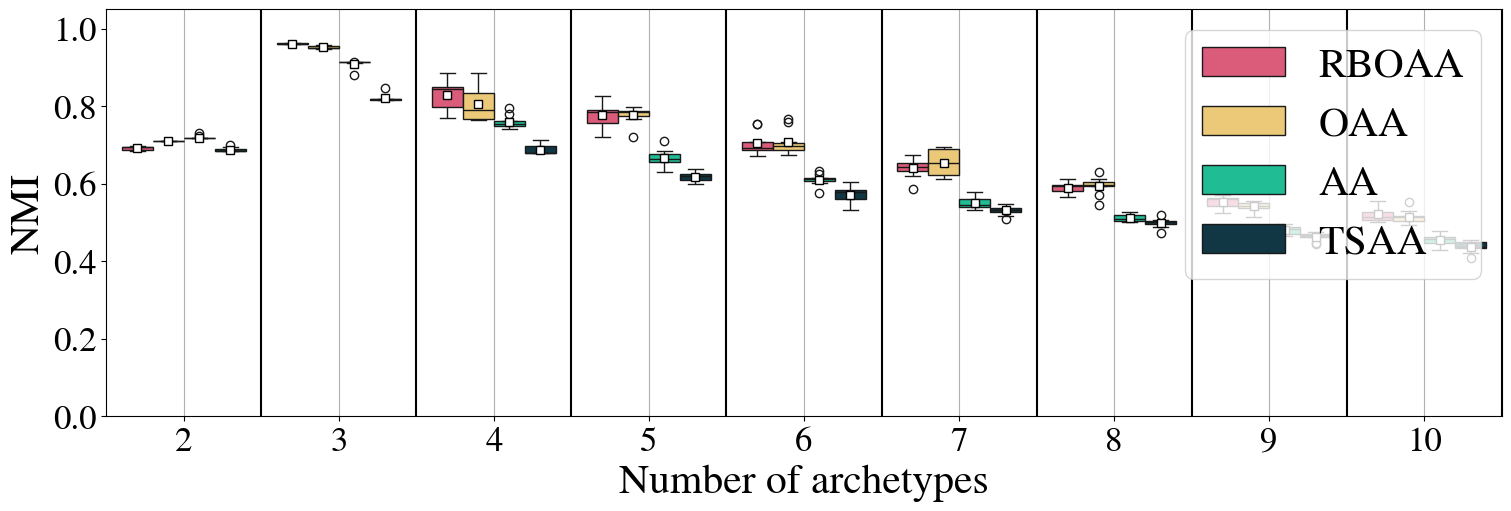

In [10]:
from src.visualizations. NMI_archetypes import NMI_archetypes

K_list = np.arange(2,11)
NMI_archetypes(K_list,results_path = 'C:/Users/aejew/Downloads/SynthResults/noRB_20Q_results/all_AA_results.json',results_path2 =  'C:/Users/aejew/Downloads/SynthResults/no_RB_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/NMI_K_naive.png",dpi=300)

# Complex Data

In [11]:
complex_res= load_analyses("RB_20Q_results")
complex_resQ100 = load_analyses("RB_100Q_results")

complex_cor = load_analyses("RB_20Q_corrupted")
complex_corQ100 = load_analyses("RB_100Q_corrupted")

complex_osm = load_analyses("RB_20Q_OSM") ### OBS! 
complex_osm_corr = load_analyses("RB_20Q_OSM_corrupted") ### OBS! 

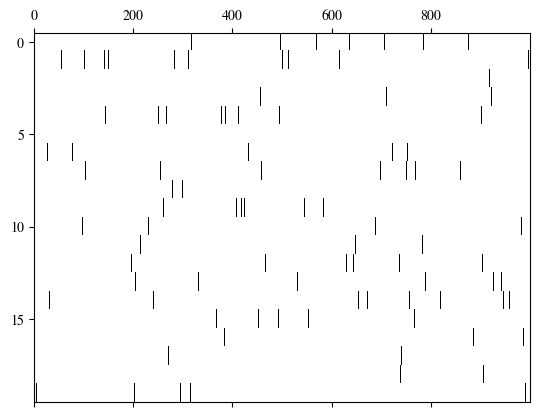

In [12]:
X = complex_res['RBOAA']['K1'][2].X
X_osm = complex_osm['TSAA']['K1'][3].X
X_cor = complex_cor['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)



RBOAA[8 7 6 4 3 2 5 1 0]
[6.47438281e+03 4.73381226e+02 6.74650669e-01 4.56388921e-01
 4.06059831e-01 6.37998505e+01 3.27605188e-01 2.95021623e-01
 2.93353885e-01]
OAA[8 7 6 5 4 3 2 1 0]
[20873.44921875 16144.39648438 12063.6875      8965.74609375
  8136.61376953  6961.68945312  6156.24316406  5528.73046875
  4948.81982422]
AA[8 7 6 5 4 3 2 1 0]
[10405.53808594  6535.34912109  4506.97753906  3443.53393555
  3052.33813477  2794.73632812  2562.74145508  2395.60620117
  2239.79711914]
TSAA[8 7 6 5 4 3 2 1 0]
[11868.79003906  7503.41210938  5208.15869141  3949.02001953
  3500.29052734  3148.19335938  2848.125       2670.88793945
  2533.66601562]


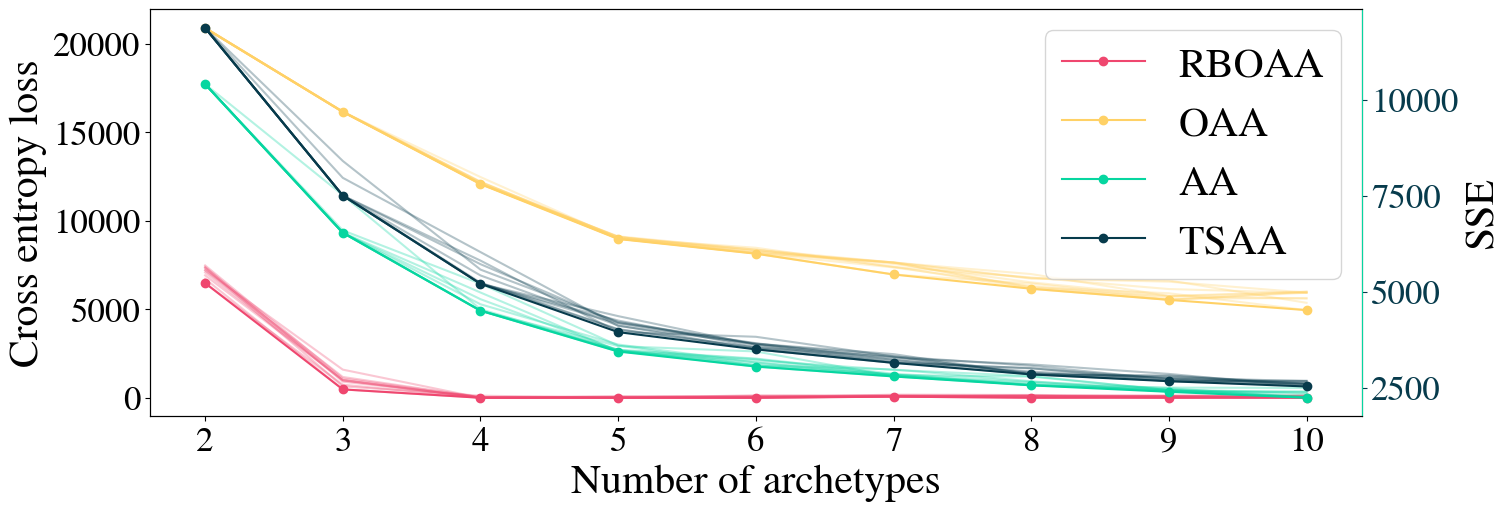

In [13]:
K_list = np.arange(2,11)
loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/SynthResults/RB_20Q_results/all_AA_results.json',results_path2 =  'C:/Users/aejew/Downloads/SynthResults/RB_20Q_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/Error_K_complex.png",dpi=300)

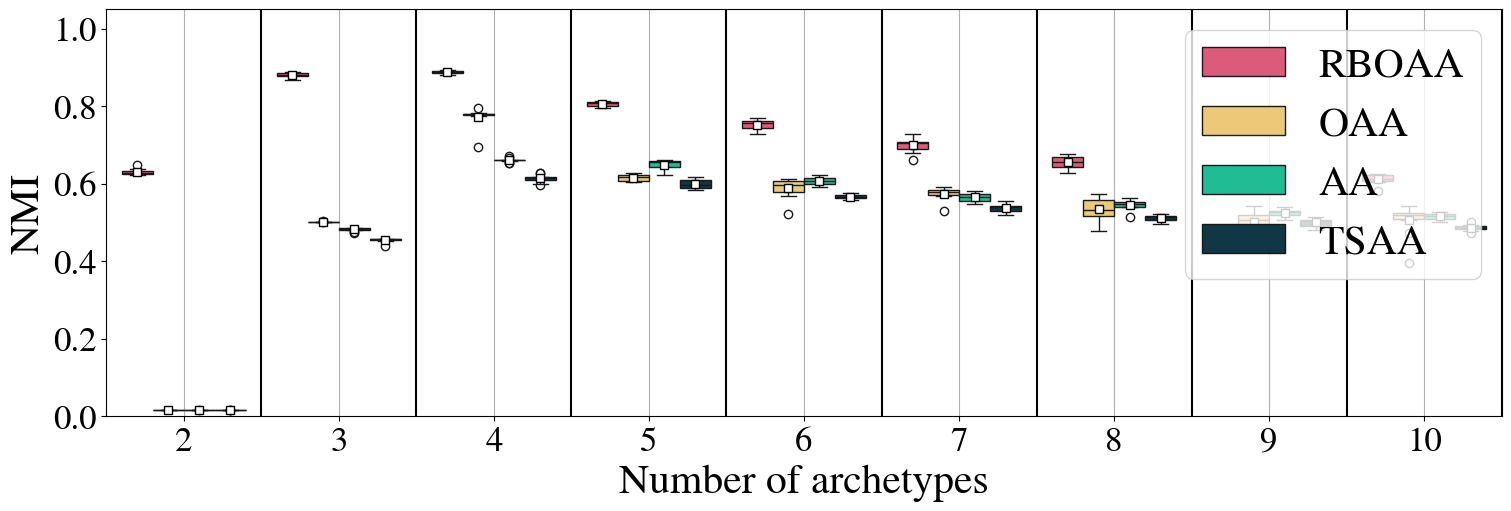

In [14]:
K_list = np.arange(2,11)
NMI_archetypes(K_list,results_path = 'C:/Users/aejew/Downloads/SynthResults/RB_20Q_results/all_AA_results.json',results_path2 =  'C:/Users/aejew/Downloads/SynthResults/RB_20Q_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/NMI_K_complex.png",dpi=300)

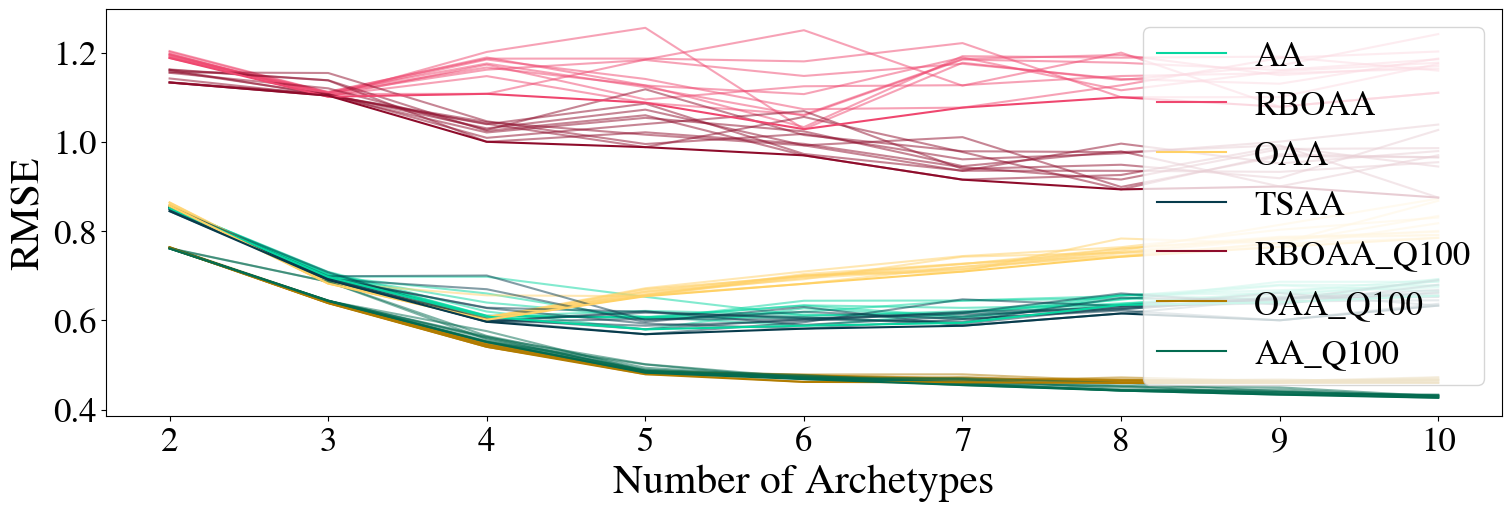

In [15]:
#from src.visualizations.denoising import denoising
p = [1,2,3,4,5]
K_list = [2,3,4,5,6,7,8,9,10]
figName= 'Denoising_complex'


denoising(complex_res,complex_cor,complex_osm_corr,complex_resQ100,complex_corQ100,K_list,p,figName)


In [20]:
Q100_RB= load_analyses("RB_100Q_results")

Q20_RB = load_analyses("RB_20Q_results")



In [21]:
from src.utils.synthetic_data_class import _synthetic_data


SD = _synthetic_data(N=1000,M=20,K=3,p=5,sigma=-9.21,rb=True,a_param =1, b_param = 1.5,sigma_std = 1e-6)
#SD2 = _synthetic_Data(N=1000,M=20,K=3,p=5,sigma=-9.21,rb=True,a_param =1, b_param = 1.5,sigma_std = 1e-6)


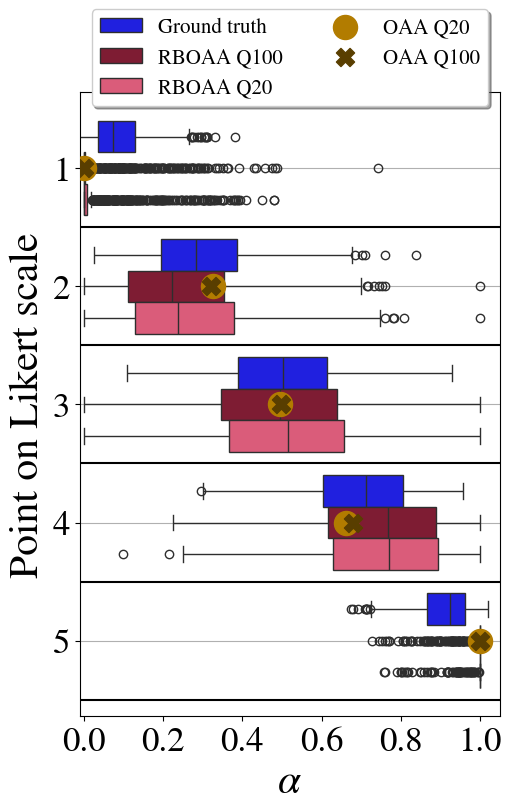

In [27]:
#from src.visualizations.response_bias import response_bias_plot
from src.visualizations.response_bias import response_bias_plot  

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'




RBOAA_betasQ100 = Q100_RB['RBOAA']['K3'][2].b
OAA_betasQ100 = Q100_RB['OAA']['K3'][2].b

RBOAA_betasQ20 = Q20_RB['RBOAA']['K3'][2].b
OAA_betasQ20 = Q20_RB['OAA']['K3'][2].b

response_bias_plot(X,  RBOAA_betasQ20, OAA_betasQ20,RBOAA_betasQ100, OAA_betasQ100 ,6, 'RB_synth', synthetic_betas=SD.betas)

#response_bias_plot(X, RBOAA_betas, OAA_betas,6,'RB_GB', synthetic_betas=SD.betas)

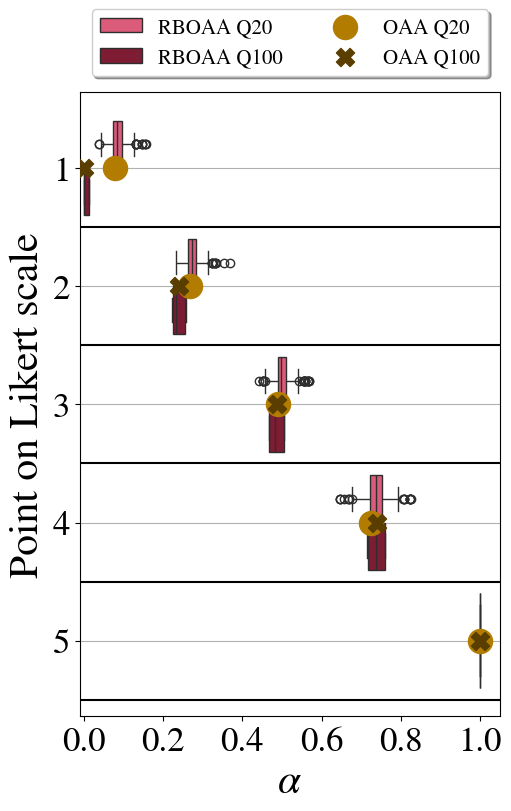

In [28]:
Q100_NoRB = load_analyses("noRB_100Q_results")
Q20_NoRB = load_analyses("noRB_20Q_results")



RBOAA_betasQ100 = Q100_NoRB['RBOAA']['K3'][2].b
OAA_betasQ100 = Q100_NoRB['OAA']['K3'][2].b

RBOAA_betasQ20 = Q20_NoRB['RBOAA']['K3'][2].b
OAA_betasQ20 = Q20_NoRB['OAA']['K3'][2].b



response_bias_plot(X,  RBOAA_betasQ20, OAA_betasQ20,RBOAA_betasQ100, OAA_betasQ100 ,6, 'noRB_synth', synthetic_betas=None)

